In [1]:
!pip install transformers tensorflow datasets kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 76.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 284.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 222.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 301.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 222.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.0/782.0 kB 297.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.1/436.1 kB 295.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 263.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 277.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 249.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 252.1 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-an

In [2]:
!if [ ! -e ~/.kaggle/kaggle.json ]; then mkdir -p ~/.kaggle; cp ~/kaggle.json ~/.kaggle; echo "Copied"; fi
!chmod 600 ~/.kaggle/kaggle.json
!ls -alR ~/.kaggle

/opt/app-root/src/.kaggle:
total 12
drwxrwsr-x.  2 1006090000 1006090000 4096 Oct  5 08:28 .
drwxrwsr-x. 14 root       1006090000 4096 Oct  6 10:42 ..
-rw-------.  1 1006090000 1006090000   69 Oct  5 08:28 kaggle.json


In [3]:
# Create directory to save results
!mkdir -p models

# https://nihcc.app.box.com/v/ChestXray-NIHCC

#kaggle datasets list
!rm -rf chest_xray
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!if [ ! -d chest_xray.dataset ]; then unzip -q chest-xray-pneumonia.zip; mv chest_xray chest_xray.dataset; fi
!rm -rf chest_xray.dataset/__MACOSX
!echo "Download complete"

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
Download complete


In [4]:
import tensorflow as tf
#from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

2024-10-06 22:39:04.040982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 22:39:04.041047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 22:39:04.042510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 22:39:04.050526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 22:39:05.081352: W tensorflow/comp

Number of replicas: 1
2.15.1


In [34]:
def tuple_prefix(tpl, element):
    lst = list(tpl)
    lst.insert(0, element)
    return tuple(lst)

def tuple_append(tpl, element):
    lst = list(tpl)
    lst.append(element)
    return tuple(lst)


INPUT_SIZE = (228,228) # use the same pixel h * w target size for all images processed
MODEL_INPUT_SHAPE = tuple_append(INPUT_SIZE, 3)
MODEL_FEATURE_SHAPE = (7,7,512)
MODEL_FEATURE_LEN = MODEL_FEATURE_SHAPE[0]*MODEL_FEATURE_SHAPE[1]*MODEL_FEATURE_SHAPE[2]

vgg_base = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=MODEL_INPUT_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

print('VGG19 Loaded')
print(vgg_base.summary())

VGG19 Loaded
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 228, 228, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 228, 228, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)

In [35]:
# Get model to output 3D feature maps (height, width, features)
altmodel = tf.keras.models.Sequential()

# Layer 1
altmodel.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=MODEL_INPUT_SHAPE))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 2
altmodel.add(tf.keras.layers.Conv2D(32, (3, 3)))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Layer 3
altmodel.add(tf.keras.layers.Conv2D(64, (3, 3)))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Apply flattening function to convert 3D feature maps in to 1D feature vectors
altmodel.add(tf.keras.layers.Flatten())  

# Add 2 final dense layers to add a classifier to the convolutional base
altmodel.add(tf.keras.layers.Dense(64))
altmodel.add(tf.keras.layers.Activation('relu'))
altmodel.add(tf.keras.layers.Dropout(0.5))
altmodel.add(tf.keras.layers.Dense(1))
altmodel.add(tf.keras.layers.Activation('sigmoid'))

# Compile the model
altmodel.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Print model summary
print(altmodel.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 226, 226, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 226, 226, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 113, 113, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 111, 111, 32)      9248      
                                                                 
 activation_6 (Activation)   (None, 111, 111, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                 

Processing chest_xray.dataset/val...
Listing chest_xray.dataset/val/NORMAL
Sample NORMAL2-IM-1440-0001.jpeg


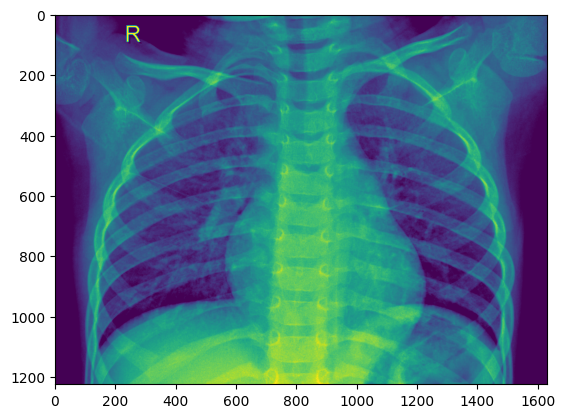

Sample NORMAL2-IM-1436-0001.jpeg


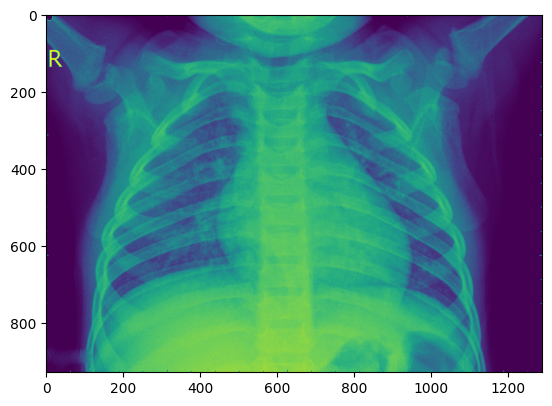

Listing chest_xray.dataset/val/PNEUMONIA
Sample person1954_bacteria_4886.jpeg


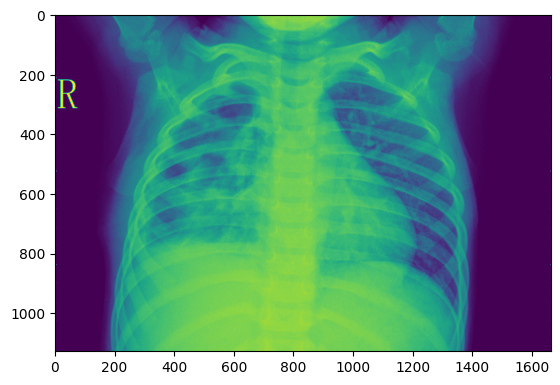

Sample person1951_bacteria_4882.jpeg


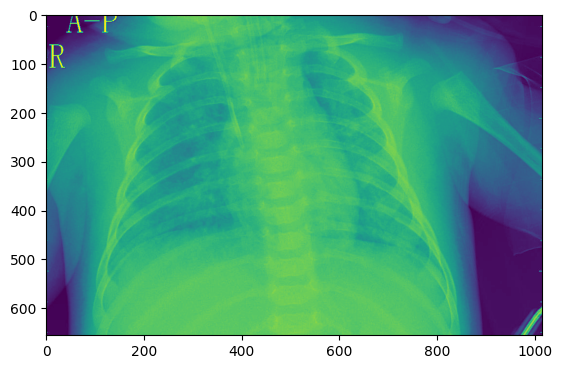

Found 16 images belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Processing chest_xray.dataset/train...
Listing chest_xray.dataset/train/NORMAL
Sample NORMAL2-IM-0932-0001.jpeg


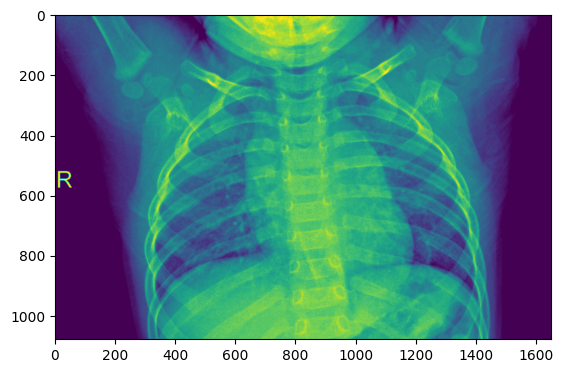

Sample NORMAL2-IM-0818-0001-0002.jpeg


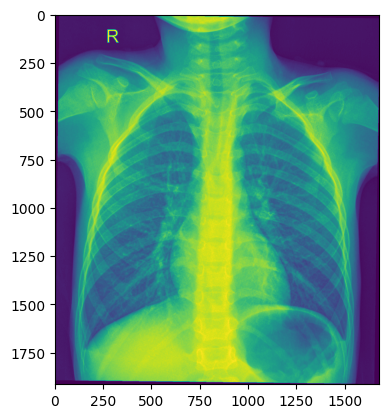

Listing chest_xray.dataset/train/PNEUMONIA
Sample person81_virus_153.jpeg


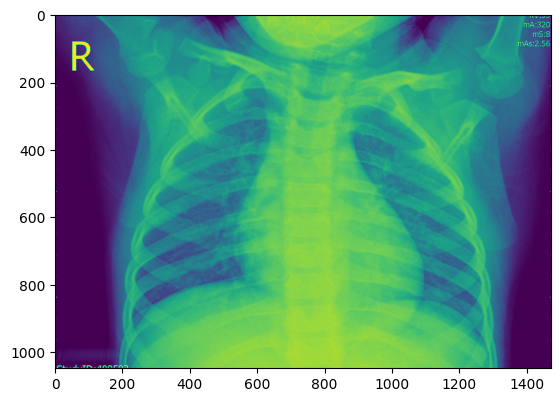

Sample person1320_bacteria_3347.jpeg


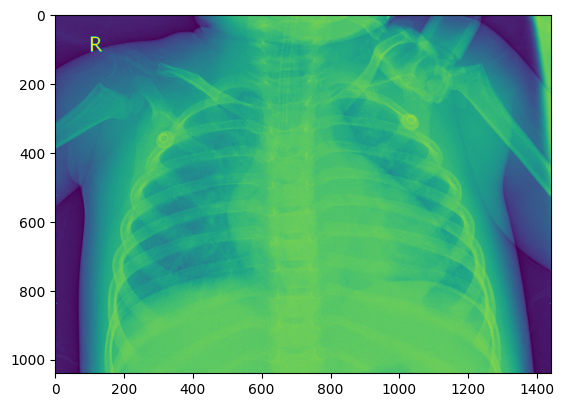

Found 5216 images belonging to 2 classes.
1/2 [==============>...............] - ETA: 5s

In [ ]:
import os, matplotlib, numpy
import matplotlib.image, matplotlib.pyplot

# Specify dataset size
DEFAULT_BATCH_SIZE = 50
DEFAULT_EPOCHS = 10 # 30

# Specify reference for directory paths
dataset_root = "chest_xray.dataset"
classifications = [ "NORMAL", "PNEUMONIA" ]
folders = [ "val", "train", "test" ]

def show_image(filename):
    img = matplotlib.image.imread(filename)
    matplotlib.pyplot.imshow(img)
    matplotlib.pyplot.show()    

#def preprocess_data(examples):
def dataset_size(directory, labels, showSample=False):
    size = 0 
    for label in labels:
        path = "{}/{}".format(directory, label)
        print("Listing {}".format(path))
        contents = os.listdir(path)
        size += len(contents)
        if showSample:
            for pic_file in  numpy.random.choice(contents, 2):
                print("Sample {}".format(pic_file))
                show_image("{}/{}".format(path,pic_file))
    return size    

def extract_features(directory, sample_amount, batch_size=0):
    if batch_size < 1:
        batch_size = DEFAULT_BATCH_SIZE
    
    features = numpy.zeros(shape=tuple_prefix(MODEL_FEATURE_SHAPE, sample_amount)) 
    labels = numpy.zeros(shape=(sample_amount))
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255) 
    generator = datagen.flow_from_directory(
        directory, target_size=INPUT_SIZE, 
        batch_size = batch_size, 
        class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        #print("Inputs: {}".format(inputs_batch))
        #print("Labels: {}".format(labels_batch))
        features_batch = vgg_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

# Apply extraction function to 3 datasets

dataset = {}

for folder in folders:
    dataset[folder] = {}
    path = "{}/{}".format(dataset_root, folder)
    print("Processing {}...".format(path))
    num_samples = dataset_size(path, classifications, True)
    #num_samples = min(1000, num_samples)
    features, labels = extract_features(path, num_samples)
    dataset[folder]['features'] = features
    dataset[folder]['labels'] = labels
    dataset[folder]['size'] = num_samples

print("Complete")


In [37]:
# Shape data
for folder in folders:
    print("Reprocessing {}...".format(folder))
    dataset[folder]['features'] = numpy.reshape(dataset[folder]['features'], (len(dataset[folder]['features']), MODEL_FEATURE_LEN))

print("Complete")

Reprocessing val...
Reprocessing train...
Reprocessing test...
Complete


In [39]:
# Configure augmentation for training adversity
# ImageDataGenerator rescales the pixels between zero and one
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Set augmentation for testing
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

generators = {}
for folder in folders:
    # Read pictures in 'data/train' directory and generate batches of image data with binary labels
    path = "{}/{}".format(dataset_root, folder)
    print("Processing {}...".format(path))
    generator = train_datagen.flow_from_directory(
        path,  
        target_size=INPUT_SIZE,
        batch_size=DEFAULT_BATCH_SIZE,  # Batch size defines the number of samples that will be propagated through the network
        class_mode='binary')
    generators[folder] = generator

print("Complete")

Processing chest_xray.dataset/val...
Found 16 images belonging to 2 classes.
Processing chest_xray.dataset/train...
Found 5216 images belonging to 2 classes.
Processing chest_xray.dataset/test...
Found 624 images belonging to 2 classes.
Complete


In [77]:
print(generators['test'].data_format)

channels_last


In [40]:
# Set stop to 5 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    restore_best_weights=True,
    patience=5
)

batch_size = min(DEFAULT_BATCH_SIZE, dataset['val']['size'])
print(subset['size'], DEFAULT_BATCH_SIZE, dataset[['train']'size']['train'] // batch_size, dataset['val']['size'] // batch_size)

# Save weights after implemeting callback to later compare
history = altmodel.fit(
        generators['train'],
        steps_per_epoch=dataset['train']['size'] // batch_size,
        epochs=DEFAULT_EPOCHS, # num of epochs will dictate speed of model
        validation_data=generators['val'],
        validation_steps=dataset['val']['size'] // batch_size, # Getting this wrong may result in missing val_* readings
        callbacks=[callback]
)
altmodel.save('models/model_01.keras')
print("Complete")

{'val': 16, 'train': 1000, 'test': 624} 50 62 1
Epoch 1/10
62/62 [==============================] - 99s 2s/step - loss: 0.6295 - accuracy: 0.7280 - val_loss: 1.2857 - val_accuracy: 0.5000
Epoch 2/10
62/62 [==============================] - 99s 2s/step - loss: 0.4100 - accuracy: 0.7479 - val_loss: 1.1190 - val_accuracy: 0.6875
Epoch 3/10
62/62 [==============================] - 100s 2s/step - loss: 0.3396 - accuracy: 0.8419 - val_loss: 0.8098 - val_accuracy: 0.5625
Epoch 4/10
62/62 [==============================] - 99s 2s/step - loss: 0.3290 - accuracy: 0.8702 - val_loss: 1.7887 - val_accuracy: 0.6875
Epoch 5/10
62/62 [==============================] - 101s 2s/step - loss: 0.3198 - accuracy: 0.8794 - val_loss: 1.8761 - val_accuracy: 0.6250
Epoch 6/10
62/62 [==============================] - 100s 2s/step - loss: 0.2940 - accuracy: 0.8865 - val_loss: 2.1207 - val_accuracy: 0.5625
Epoch 7/10
62/62 [==============================] - 100s 2s/step - loss: 0.2861 - accuracy: 0.8890 - val_loss

{'verbose': 1, 'epochs': 10, 'steps': 62}


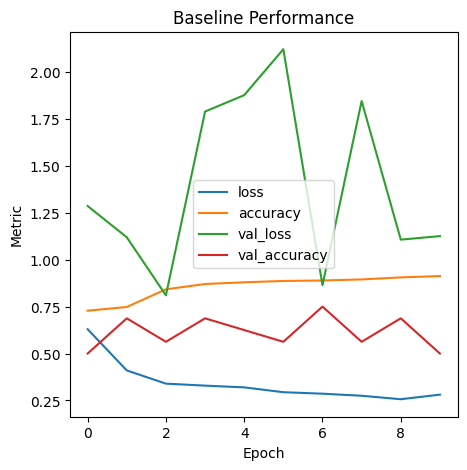

In [41]:
import pandas

print(history.params)

# Plot model training performance    
df = pandas.DataFrame(data=history.history, columns=history.history.keys())
df.plot(figsize=(5, 5))
                 
matplotlib.pyplot.title('Baseline Performance')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Metric')

# pyplot requires all rows to have the same number of keys
matplotlib.pyplot.show()

In [42]:
print("Evaluate on test data")
results = altmodel.evaluate(generators['test'], batch_size=DEFAULT_BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
13/13 [==============================] - 12s 937ms/step - loss: 0.3761 - accuracy: 0.8510
test loss, test acc: [0.37610650062561035, 0.8509615659713745]


(1, 228, 228, 3)
1/1 [==============================] - 0s 21ms/step
PNEUMONIA 


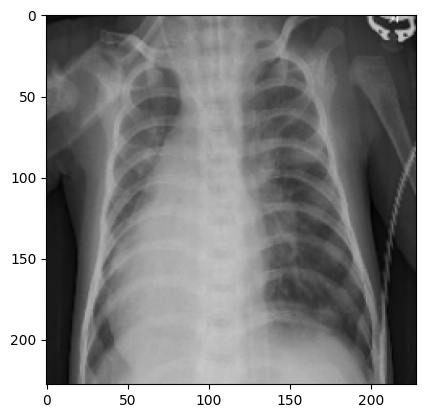


(1, 228, 228, 3)
1/1 [==============================] - 0s 21ms/step
PNEUMONIA - INCORRECT! Predicted 0.831778883934021, expected 0.0


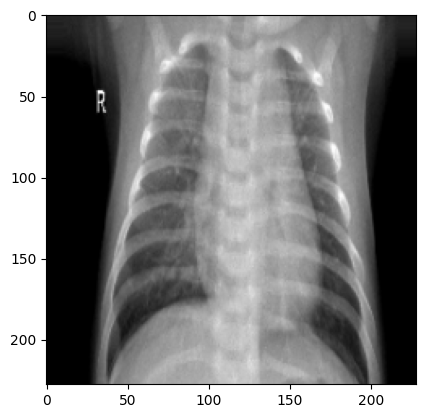


(1, 228, 228, 3)
1/1 [==============================] - 0s 21ms/step
PNEUMONIA 


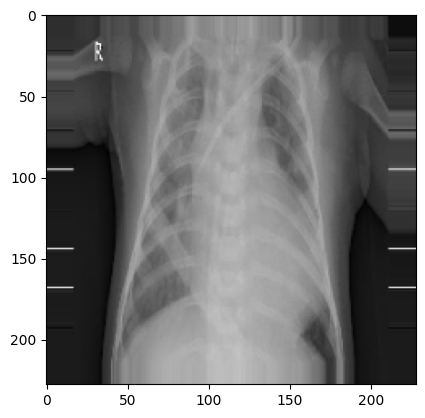


(1, 228, 228, 3)
1/1 [==============================] - 0s 21ms/step
PNEUMONIA 


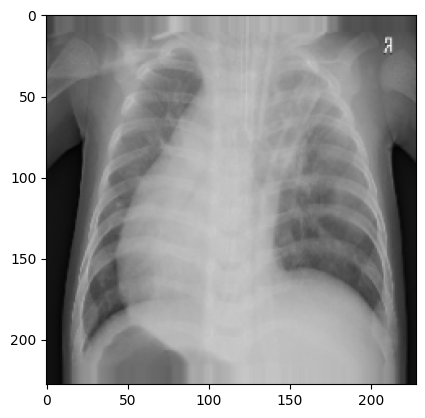


(1, 228, 228, 3)
1/1 [==============================] - 0s 22ms/step
PNEUMONIA 


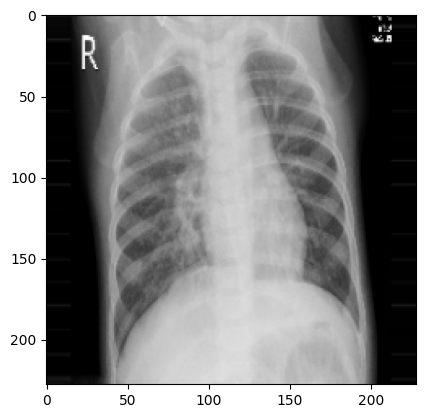

In [86]:
# Validation generator with batch size = 1 

generators['test'].batch_size = 1

# Preview examples from validation set and labels predicted from baseline model
for _ in range(5):
    gn = next(generators['test'])
    x = gn[0]
    print(x.shape)
    px = altmodel.predict(x)
    result = ''
    if px[0][0] > 0.6:
        if gn[1] != 1.0:
            result = '- INCORRECT! Predicted {}, expected {}'.format(px[0][0],gn[1][0])
        print('PNEUMONIA {}'.format(result))
    elif px[0][0] < 0.4:
        if gn[1] != 0.0:
            result = '- INCORRECT! Predicted {}, expected {}'.format(px[0][0],gn[1][0])
        print('NORMAL {}'.format(result))
    else:
        print('UNDECIDED')
        
        

    matplotlib.pyplot.imshow(x.reshape(MODEL_INPUT_SHAPE))
    matplotlib.pyplot.show()
    print()

In [100]:
import random
images = []

count = 5
filter="NORMAL"
while (count > 0):
    filepath = generators['test'].filenames[random.randrange(dataset['test']['size'])]
    if filter in filepath:
        images.append("{}/{}/{}".format(dataset_root, 'test', filepath))
        count -= 1

for image_path in images:
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        target_size=INPUT_SIZE,
        color_mode="rgb",
        interpolation="nearest",
        keep_aspect_ratio=False)  # this is a PIL image
    x = tf.keras.preprocessing.image.img_to_array(img, data_format=generators['test'].data_format)  # this is a Numpy array with shape (3, 150, 150)
    print(x.shape)

    # Predict expects a an array of images
    xr = tf.expand_dims(x, axis=0)
    print(xr.shape)

    px = altmodel.predict(xr)
    if px[0][0] > 0.6:
        result = '- Predicted {} for {}'.format(px[0][0],image_path)
        print('PNEUMONIA {}'.format(result))
    elif px[0][0] < 0.4:
        result = '- Predicted {} for {}'.format(px[0][0],image_path)
        print('NORMAL {}'.format(result))
    else:
        print('UNDECIDED')


(228, 228, 3)
(1, 228, 228, 3)
1/1 [==============================] - 0s 22ms/step
PNEUMONIA - Predicted 1.0 for chest_xray.dataset/test/NORMAL/IM-0089-0001.jpeg
(228, 228, 3)
(1, 228, 228, 3)
1/1 [==============================] - 0s 23ms/step
PNEUMONIA - Predicted 1.0 for chest_xray.dataset/test/NORMAL/IM-0084-0001.jpeg
(228, 228, 3)
(1, 228, 228, 3)
1/1 [==============================] - 0s 22ms/step
PNEUMONIA - Predicted 1.0 for chest_xray.dataset/test/NORMAL/NORMAL2-IM-0206-0001.jpeg
(228, 228, 3)
(1, 228, 228, 3)
1/1 [==============================] - 0s 22ms/step
PNEUMONIA - Predicted 1.0 for chest_xray.dataset/test/NORMAL/IM-0086-0001.jpeg
(228, 228, 3)
(1, 228, 228, 3)
1/1 [==============================] - 0s 21ms/step
PNEUMONIA - Predicted 1.0 for chest_xray.dataset/test/NORMAL/NORMAL2-IM-0028-0001.jpeg


In [87]:
# Build classifier on top of  VGG19
model = tf.keras.models.Sequential()

# Add dense layers on top of VGG19 
# 1
model.add(tf.keras.layers.Dense(256, activation='relu', input_dim=reshape_y))
# 2
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(dataset['train']['features'], dataset['train']['labels'],
                    epochs=DEFAULT_EPOCHS,
                    batch_size=16,
                    validation_data=(dataset['val']['features'], dataset['val']['labels']))

# Save VGG19 results
model.save('models/model_VGG_01.keras')

Epoch 1/10
63/63 [==============================] - 2s 23ms/step - loss: 0.3519 - acc: 0.8680 - val_loss: 0.9354 - val_acc: 0.6250
Epoch 2/10
63/63 [==============================] - 1s 21ms/step - loss: 0.1715 - acc: 0.9390 - val_loss: 0.6501 - val_acc: 0.6875
Epoch 3/10
63/63 [==============================] - 1s 22ms/step - loss: 0.1394 - acc: 0.9410 - val_loss: 2.2369 - val_acc: 0.5000
Epoch 4/10
63/63 [==============================] - 1s 22ms/step - loss: 0.1008 - acc: 0.9630 - val_loss: 0.1175 - val_acc: 1.0000
Epoch 5/10
63/63 [==============================] - 1s 21ms/step - loss: 0.1011 - acc: 0.9630 - val_loss: 0.1736 - val_acc: 0.8750
Epoch 6/10
63/63 [==============================] - 1s 21ms/step - loss: 0.0762 - acc: 0.9650 - val_loss: 0.2283 - val_acc: 0.8125
Epoch 7/10
63/63 [==============================] - 1s 23ms/step - loss: 0.0786 - acc: 0.9710 - val_loss: 0.0931 - val_acc: 1.0000
Epoch 8/10
63/63 [==============================] - 1s 21ms/step - loss: 0.0579 - a